LSTM

In [62]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [63]:
# Baixar dados históricos da ação MGLU3 dos últimos 5 anos
mglu3 = yf.download('MGLU3.SA', period="5y")


[*********************100%***********************]  1 of 1 completed


In [64]:
mglu3.head()

Price,Close,High,Low,Open,Volume
Ticker,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA
Date,,,,,
2020-02-12,130.426544,131.848794,126.486240,127.139078,4501544
2020-02-13,133.014572,133.597445,126.136510,128.048375,5878010
2020-02-14,131.335861,135.136282,130.566457,134.296921,3921638
2020-02-17,137.211365,139.706110,133.247736,135.229550,7887668
2020-02-18,135.742493,137.794249,134.063784,135.812450,4087784


In [65]:
# Pega somente o atributo "Close" e armazena em um array bidimensional
#O array precisa ser bidimensional porque o MinMaxScaler espera uma entrada com esse formato.
mglu3_close = mglu3['Close'].dropna().to_numpy().reshape(-1, 1)

In [66]:
# Criar um DataFrame com os valores ajustados
data = pd.DataFrame(mglu3_close)
data.columns = ['Close']

In [67]:
# Normalizar os dados para os modelos
scaler = MinMaxScaler(feature_range=(0, 1))
data['Scaled_Close'] = scaler.fit_transform(data[['Close']])

In [68]:
# Função para criar janelas de dados
# janela de dados = quantidade de dias do X
def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)


In [69]:
window_size = 30
scaled_data = data['Scaled_Close'].values
X, y = create_dataset(scaled_data, window_size)

In [70]:
scaled_data.shape, X.shape, y.shape

((1245,), (1215, 30), (1215,))

In [71]:
# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [72]:
# Ajustar o formato para o LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [73]:
# Criar o modelo LSTM
lstm_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.3),
    LSTM(100, return_sequences=True),
    Dropout(0.3),
    LSTM(100),
    Dropout(0.3),
    Dense(1)
])

C:\Users\ramon\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [74]:
# Compilar o modelo
# A função de loss é a forma de medir o erro do modelo, que nesse caso
#é o classico erro médio quadrático da que é usado em regressão linear
#otimizador e medida de erro

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


In [75]:
# Treinar o modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

lstm_model.fit(X_train, y_train, 
               epochs=100, 
               batch_size=32, 
               validation_data=(X_test, y_test),
               callbacks=[early_stopping, reduce_lr], 
               verbose=1)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0592 - val_loss: 1.3246e-04 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0079 - val_loss: 5.2051e-05 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0044 - val_loss: 3.6831e-05 - learning_rate: 0.0010
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0052 - val_loss: 8.9276e-05 - learning_rate: 0.0010
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0040 - val_loss: 5.4815e-05 - learning_rate: 0.0010
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0039 - val_loss: 6.0624e-05 - learning_rate: 0.0010
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0043 - val_loss: 5.2965e-05 - learning_rate: 5.0000e-04
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0035 - val_loss: 2.5427e-05 - learning_rate: 5.0000e-04
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0034 - val_loss: 6

In [76]:
# Fazer previsões
lstm_predictions = lstm_model.predict(X_test)

# Inverter a normalização
lstm_predictions = scaler.inverse_transform(lstm_predictions)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [96]:
len(X_train)

972

In [77]:
df_teste = pd.DataFrame({
    "Date": mglu3.index[len(X_train) + window_size : len(X_train) + window_size + len(lstm_predictions)],  # Pegando as datas corretas
    "Real": mglu3['Close'].iloc[len(X_train) + window_size : len(X_train) + window_size + len(lstm_predictions)].values.flatten(),
    "Previsão": lstm_predictions.flatten()
})

# Garantindo que a coluna "Date" seja de fato uma data (caso ainda não seja)
df_teste["Date"] = pd.to_datetime(df_teste["Date"])

# Definir "Date" como índice (opcional, se quiser que o gráfico fique melhor organizado)
df_teste.set_index("Date", inplace=True)

In [84]:
df_teste

,Real,Previsão
Date,,
2024-02-27,22.000000,20.085083
2024-02-28,21.700001,20.177061
2024-02-29,21.299999,20.284542
2024-03-01,22.200001,20.395706
2024-03-04,21.299999,20.517231
...,...,...
2025-02-06,7.390000,5.950135
2025-02-07,7.070000,6.044992
2025-02-10,7.260000,6.132034


In [79]:
# Calcular métricas
mae = mean_absolute_error(df_teste["Real"], df_teste["Previsão"])
mse = mean_squared_error(df_teste["Real"], df_teste["Previsão"])
rmse = np.sqrt(mse)
r2 = r2_score(df_teste["Real"], df_teste["Previsão"])

# Exibir resultados
print(f"📊 MÉTRICAS DE ERRO DO MODELO LSTM 📊")
print(f"MAE  (Erro Absoluto Médio)  : {mae:.4f}")
print(f"MSE  (Erro Quadrático Médio): {mse:.4f}")
print(f"RMSE (Raiz do Erro Médio)   : {rmse:.4f}")
print(f"R²   (Coeficiente de Determinação): {r2:.4f}")


📊 MÉTRICAS DE ERRO DO MODELO LSTM 📊
MAE  (Erro Absoluto Médio)  : 0.9517
MSE  (Erro Quadrático Médio): 1.3229
RMSE (Raiz do Erro Médio)   : 1.1502
R²   (Coeficiente de Determinação): 0.9148


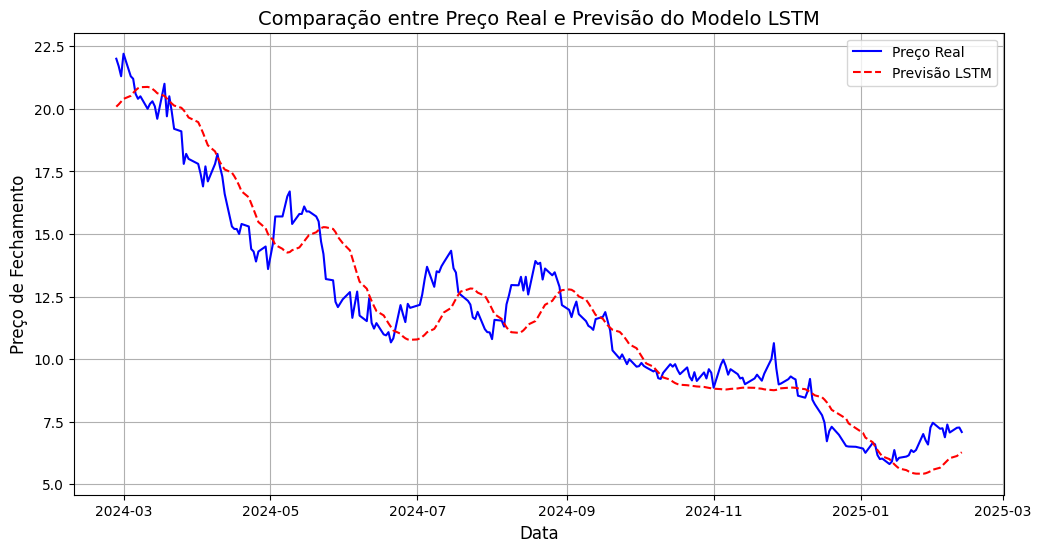

In [80]:
import matplotlib.pyplot as plt

# Criar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_teste.index, df_teste["Real"], label="Preço Real", linestyle="-", color="blue")
plt.plot(df_teste.index, df_teste["Previsão"], label="Previsão LSTM", linestyle="--", color="red")

# Adicionar títulos e legendas
plt.title("Comparação entre Preço Real e Previsão do Modelo LSTM", fontsize=14)
plt.xlabel("Data", fontsize=12)
plt.ylabel("Preço de Fechamento", fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar o gráfico
plt.show()


In [ ]:
# Prever o preço de fechamento para os próximos 5 dias
predicted_prices = []
last_window_days = scaled_data[-window_size:]  # Última janela da série (valores reais)
last_window_days = last_window_days.reshape(1, window_size, 1)  # Ajustar a forma para o LSTM

for _ in range(5):  # Loop para prever os próximos 5 dias
    # Prever o próximo dia
    predicted_price_scaled = lstm_model.predict(last_window_days)
    predicted_price = scaler.inverse_transform(predicted_price_scaled)
    
    # Adicionar a previsão à lista de preços previstos
    predicted_prices.append(predicted_price[0][0])
    
    # Atualizar 'last_window_days' com o novo preço previsto
    last_window_days = np.append(last_window_days[:, 1:, :], predicted_price_scaled.reshape(1, 1, 1), axis=1)

# Exibir os preços previstos para os próximos 5 dias
for i, price in enumerate(predicted_prices, 1):
    print(f"Preço previsto para o dia {i} (amanhã): R${price:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Preço previsto para o dia 1 (amanhã): R$6.34
Preço previsto para o dia 2 (amanhã): R$6.38
Preço previsto para o dia 3 (amanhã): R$6.39
Preço previsto para o dia 4 (amanhã): R$6.38
Preço previsto para o dia 5 (amanhã): R$6.35
